In [253]:
import random
from datetime import datetime, timedelta
import numpy
import pandas 

class TimeSeriesDataGenerator:
    def __init__(self, start_date, end_date, num_points):
        self.start_date = datetime.strptime(start_date, '%Y-%m-%d')
        self.end_date = datetime.strptime(end_date, '%Y-%m-%d')
        self.num_points = num_points
        self.data = self.generate_data()

    def generate_data(self):
        dates = []
        values = []
        delta = (self.end_date - self.start_date) / (self.num_points - 1)
        # Random trend: random value between -1 and 1
        trend = random.uniform(-1, 1)
        # Random seasonality: random period between num_points / 10 and num_points / 2
        seasonality_period = random.uniform(self.num_points / 10, self.num_points / 2)
        for i in range(self.num_points):
            date = self.start_date + i * delta
            # Trend: linearly increasing values
            trend_component = trend * i / self.num_points
            # Seasonality: sine wave with a random period
            seasonality_component = numpy.sin(2 * numpy.pi * i / seasonality_period)
            # Random noise
            noise = random.uniform(-0.2, 0.2)
            value = trend_component + seasonality_component + noise
            dates.append(date)
            values.append(value)
        values = [value if numpy.isfinite(value) else 0 for value in values] # Replace infinite and NaN values with a default value
        if not numpy.all(numpy.isfinite(values)):
            raise ValueError("Generated data contains infinite or NaN values")
        return pandas.Series(values, index=dates)

    def __len__(self):
        return len(self.data)

class GARCHTimeSeriesDataGenerator:
    def __init__(self, start_date, mu=0, omega=0.1, alpha=[0.5], beta=[0.5]):
        self.start_date = pandas.to_datetime(start_date)
        self.mu = mu
        self.omega = omega
        self.alpha = alpha
        self.beta = beta

    def simulate(self, n):
        # Initialize arrays
        errors = numpy.random.normal(size=n)
        sigmas = numpy.zeros_like(errors)
        returns = numpy.zeros_like(errors)

        # Simulate GARCH process
        for t in range(1, n):
            sigmas[t] = numpy.sqrt(self.omega + self.alpha[0] * errors[t-1]**2 + self.beta[0] * sigmas[t-1]**2)
            returns[t] = self.mu + sigmas[t] * errors[t]

        # Create date range
        dates = pandas.date_range(self.start_date, periods=n)

        # Create pandas Series
        simulated_series = pandas.Series(returns, index=dates)

        return simulated_series

In [256]:
#og_data = TimeSeriesDataGenerator('2019-01-01', '2019-01-10', 400).data
og_data = GARCHTimeSeriesDataGenerator('2019-01-01').simulate(400)
time_series_data = og_data

In [257]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas
from pandas.plotting import lag_plot, autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_pacf


class TimeSeriesVisualizer:
    def __init__(self, time_series):
        self.time_series = time_series
        # Set the style of the plots to a professional one
        sns.set_style("whitegrid")
        # Set a consistend color palette
        sns_color_palette = sns.color_palette("bright", as_cmap=True)
        # Set a consistent color palette
        sns.set_palette(sns_color_palette)

    def scatter_plot(self):
        plt.figure(figsize=(10, 6))  # Set figure size
        df = self.time_series.reset_index()
        df.columns = ['date', 'value']
        sns.scatterplot(x='date', y='value', data=df)
        plt.title("Scatter Plot of Times Series Data")
        plt.xlabel("Date")
        plt.ylabel("Value")
        plt.xticks(rotation=45)  # Rotate x-axis labels
        plt.legend(bbox_to_anchor=(1.1, 1.05), title = 'Legend')
        plt.show()

    def line_plot(self, window_size=7, function='mean'):
        
        plt.figure(figsize=(10, 6))  # Set figure size
        df = self.time_series.reset_index()
        df.columns = ['date', 'value']
        sns.lineplot(x='date', y='value', data=df, label="Original Series")
        
        
        # Apply rolling window function
        if function == 'mean':
            df['rolling'] = df['value'].rolling(window_size).mean()
        elif function == 'sum':
            df['rolling'] = df['value'].rolling(window_size).sum()
        else:
            raise ValueError(f"Unsupported function: {function}. Supported functions are 'mean' and 'sum'.")
        sns.lineplot(x='date', y='rolling', data=df, label=f'Rolling {function} (window={window_size})')

        # Apply expanding window function
        # Note: expanding() does not take a window size
        if function == 'mean':
            df['expanding'] = df['value'].expanding().mean()
        elif function == 'sum':
            df['expanding'] = df['value'].expanding().sum()
        else:
            raise ValueError(f"Unsupported function: {function}. Supported functions are 'mean' and 'sum'.")
        sns.lineplot(x='date', y='expanding', data=df, label=f'Expanding {function}')

    
        sns.lineplot(x='date', y='rolling', data=df, label=f'Rolling {function} (window={window_size})')
        plt.title("Line Plot of Times Series Data")
        plt.xlabel("Date")
        plt.ylabel("Value")
        plt.xticks(rotation=45)  # Rotate x-axis labels
        plt.legend(bbox_to_anchor=(1.1, 1.05), title = 'Legend')
        plt.show()

    def histogram_plot(self):
        plt.figure(figsize=(10, 6))  # Set figure size
        sns.histplot(data=self.time_series)
        plt.title(f"Histogram Plot of Times Series Data")
        plt.xlabel("Date")
        plt.xticks(rotation=45)  # Rotate x-axis labels
        plt.legend(bbox_to_anchor=(1.1, 1.05), title = 'Legend')
        plt.show()
        
    def area_plot(self):
        plt.figure(figsize=(10, 6))
        if not hasattr(self.time_series, 'index'):
            self.time_series.index = pandas.RangeIndex(start=0, stop=len(self.time_series))
        plt.figure(figsize=(10, 6))
        plt.fill_between(self.time_series.index, self.time_series.values)
        plt.title("Area Plot of Time Series Data")
        plt.xlabel("Date")
        plt.ylabel("Value")
        plt.xticks(rotation=45)  # Rotate x-axis labels
        plt.legend(bbox_to_anchor=(1.1, 1.05), title = 'Legend')
        plt.show()

    def box_plot(self):
        plt.figure(figsize=(10, 6))
        sns.boxplot(data=self.time_series)
        plt.title("Box Plot of Time Series Data")
        plt.xlabel("Date")
        plt.ylabel("Value")
        plt.xticks(rotation=45)  # Rotate x-axis labels
        plt.legend(bbox_to_anchor=(1.1, 1.05), title = 'Legend')
        plt.show()

    def lag_plot(self, lag_time = 1):
        plt.figure(figsize=(10, 6))
        lag_plot(self.time_series, lag=lag_time)
        plt.title(f"Lag Plot of Time Series Data: Lag Time of {lag_time}")
        plt.legend(bbox_to_anchor=(1.1, 1.05), title = 'Legend')
        plt.show()

    def autocorrelation_plot(self):
        plt.figure(figsize=(10, 6))
        autocorrelation_plot(self.time_series)
        plt.title("Autocorrelation Plot of Time Series Data")

        # Calculate autocorrelation values starting from lag 1
        self._autocorr_values = [self.time_series.autocorr(lag=lag) for lag in range(1, len(self.time_series))]

        # Find highest and lowest autocorrelation values and their respective lag intervals
        max_autocorr = max(self._autocorr_values)
        min_autocorr = min(self._autocorr_values)
        max_lag = self._autocorr_values.index(max_autocorr) + 1  # Add 1 because we started from lag 1
        min_lag = self._autocorr_values.index(min_autocorr) + 1  # Add 1 because we started from lag 1

        # Add vertical lines to indicate lags with highest and lowest autocorrelation values
        plt.axvline(x=max_lag, color='r', linestyle='--')
        plt.axvline(x=min_lag, color='b', linestyle='--')

        # Display highest and lowest autocorrelation values in the legend
        plt.legend([f'Max: {max_autocorr:.2f} (Lag: {max_lag})', f'Min: {min_autocorr:.2f} (Lag: {min_lag})'], 
                title = 'Autocorrelation values', loc='upper right')

        plt.show()
        
    def partial_autocorrelation_plot(self):
        plt.figure(figsize=(10, 6))
        plot_pacf(self.time_series, lags = len(self.time_series) * .49)
        plt.title("Partial Autocorrelation Plot of Time Series Data")
        plt.show()
        
    def visualize_all(self):
        try:
            for method_name in dir(self):
                if method_name.endswith('_plot'):
                    method = getattr(self, method_name)
                    method()
        except SystemError as e: 
            print(f"There was an error in the {method_name} method: {e}")


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 1000x600 with 0 Axes>

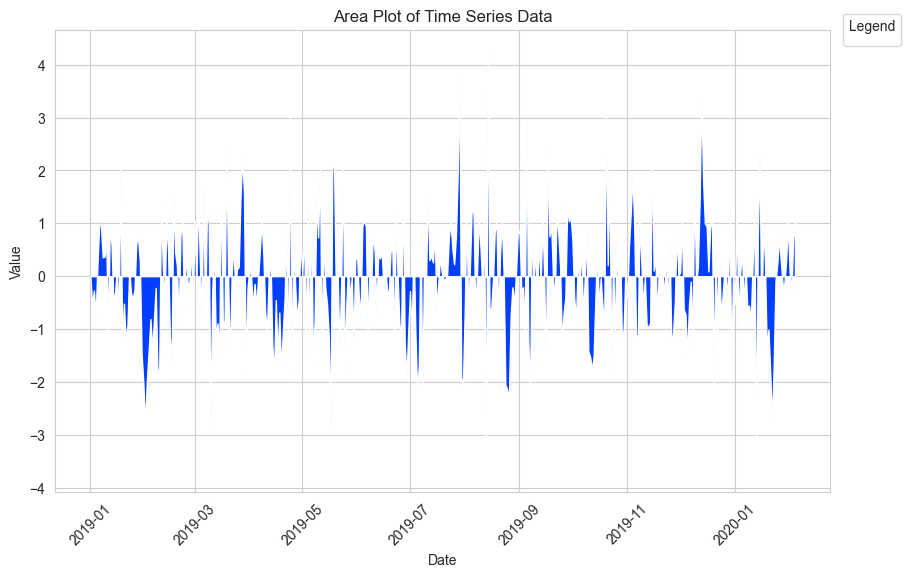

C:\Users\josep\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\lib\function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\josep\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\josep\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


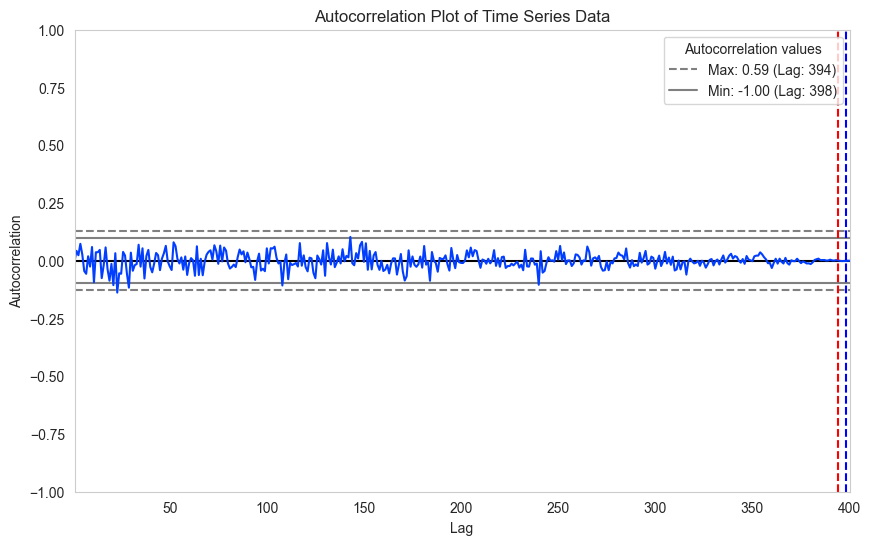

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


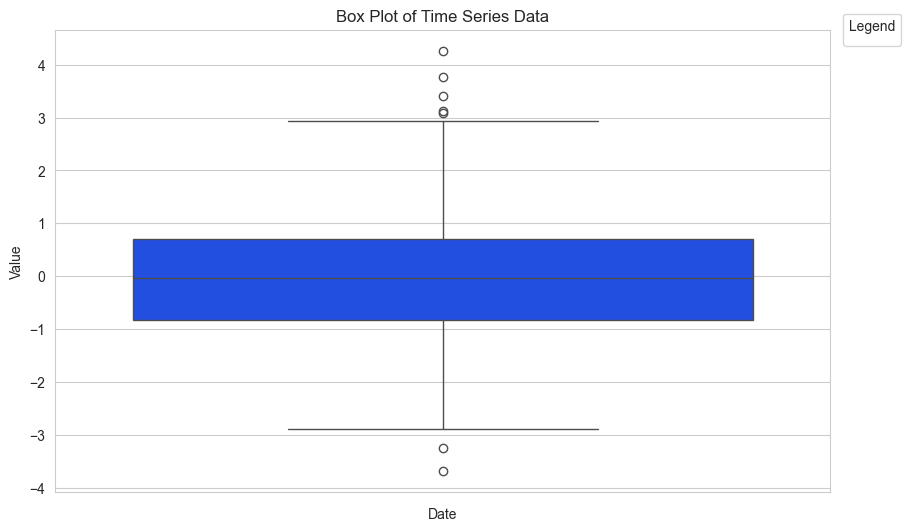

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


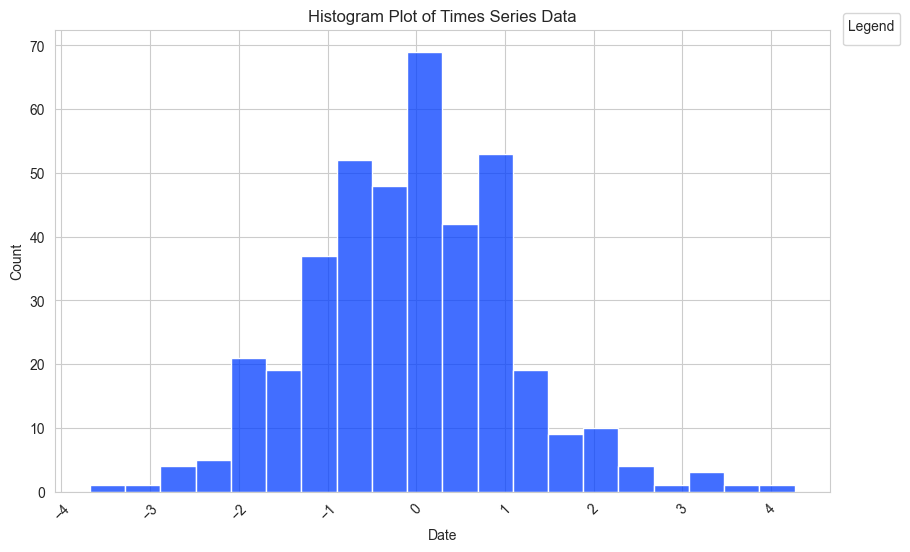

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


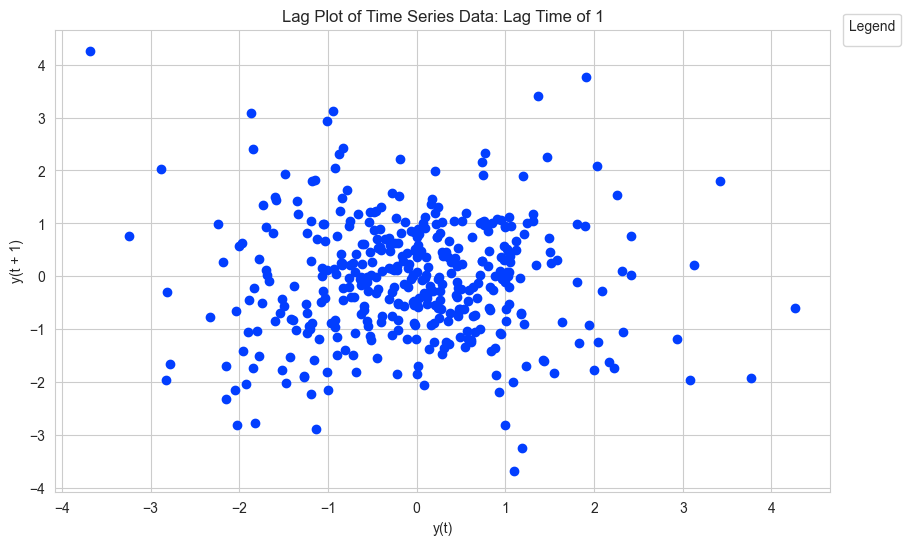

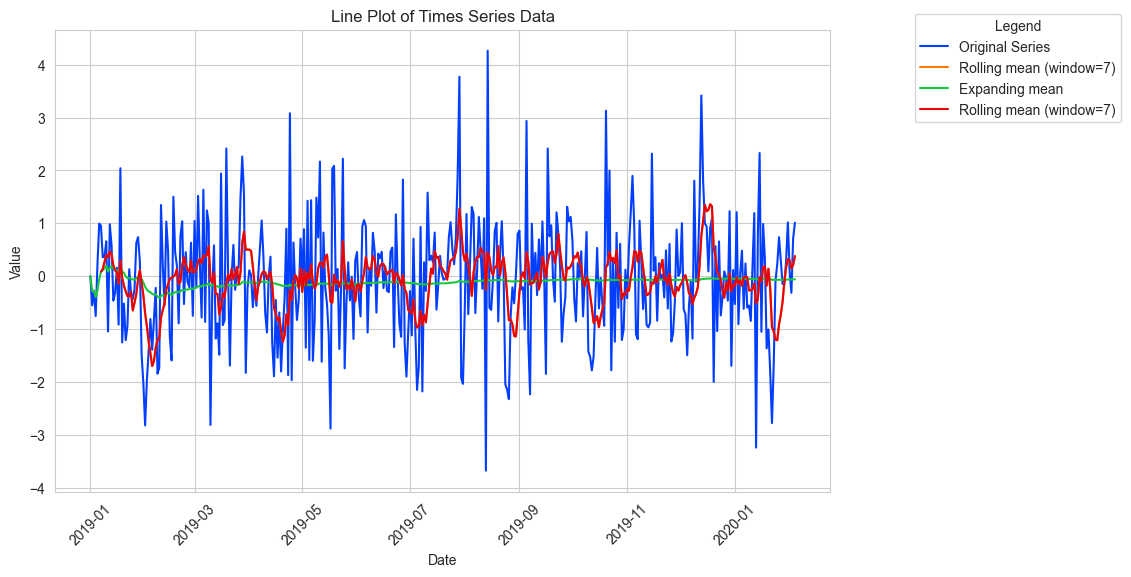

<Figure size 1000x600 with 0 Axes>

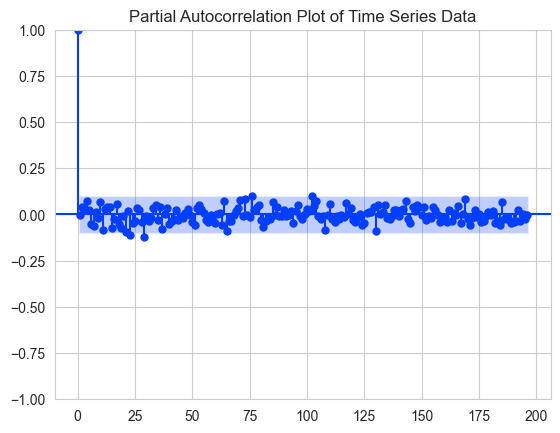

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


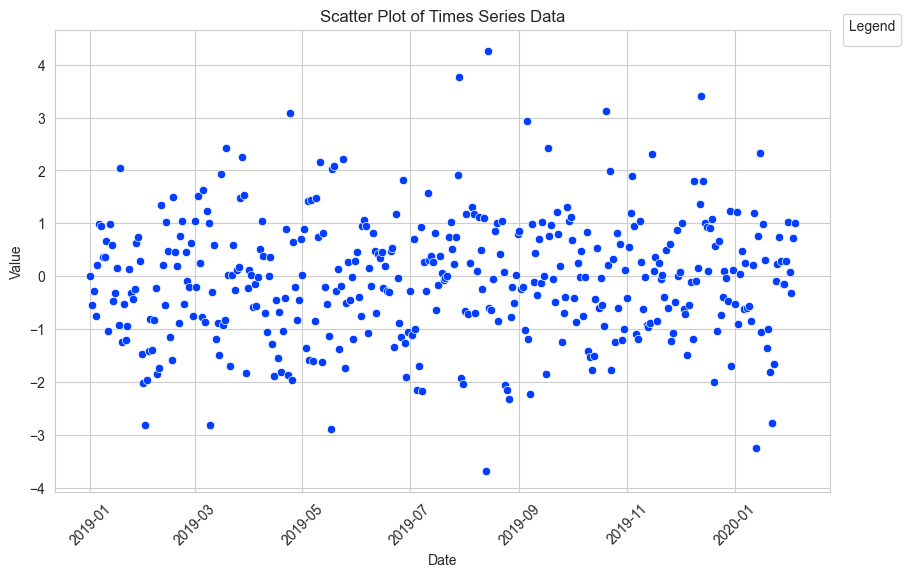

In [258]:
time_series_visualizer = TimeSeriesVisualizer(time_series_data)
time_series_visualizer.visualize_all()

In [259]:
from statsmodels.tsa.stattools import adfuller
import numpy as np

class StationarityTester:
    def __init__(self, time_series_generator):
        self.time_series = time_series_generator
        if not np.all(np.isfinite(self.time_series)):
            raise ValueError("Time series contains NaN or Inf values")

    def test_stationarity(self, timeseries, confidence_level=0.05):
        # Perform Dickey-Fuller test:
        print('Results of Dickey-Fuller Test:')
        dftest = adfuller(timeseries, autolag='AIC')
        dfoutput = pandas.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
        for key,value in dftest[4].items():
            dfoutput['Critical Value (%s)'%key] = value
        print(dfoutput)
        
        p_value = dfoutput['p-value']
        if p_value < confidence_level:
            print(f"--Your data is stationary, as the p-value ({p_value}) is less than your specified confidence level ({confidence_level}).")
        else:
            print(f"--Your data is not stationary, as the p-value ({p_value}) is greater than your specified confidence level ({confidence_level}).")
            
        return dfoutput['p-value']

    def make_stationary(self):
        print("---- Original Series Stationarity Test ----")
        p_value_original = self.test_stationarity(self.time_series)
        print(f"--Original series p-value: {p_value_original}")
        print("\n")
        
        # Shift the series to handle zero or negative values
        shift = abs(min(self.time_series)) + 1e-10
        adjusted_series = self.time_series + shift

        # Apply log transformation
        log_transformed = np.log(adjusted_series)
        print("---- Log Transformation Stationarity Test ----")
        p_value_log = self.test_stationarity(log_transformed)
        print(f"-- Log transformed series p-value: {p_value_log}")
        print("\n")

        # Apply square root transformation
        sqrt_transformed = np.sqrt(adjusted_series)
        print("---- Square Root Transformation Stationarity Test ----")
        p_value_sqrt = self.test_stationarity(sqrt_transformed)
        print(f"-- Square root transformed series p-value: {p_value_sqrt}")
        print("\n")

        # Compare p-values and return the most stationary series
        if min(p_value_original, p_value_log, p_value_sqrt) == p_value_log:
            print("Log transformation resulted in the most stationary series. Returning the log transformed series.")
            log_transformed._transformed_series_type = 'log'
            return log_transformed
        elif min(p_value_original, p_value_log, p_value_sqrt) == p_value_sqrt:
            print("Square root transformation resulted in the most stationary series. Returning the square root transformed series.")
            sqrt_transformed._transformed_series_type = 'sqrt'
            return sqrt_transformed
        else:
            print("The original series is the most stationary.")
            self.time_series._transformed_series_type = 'original'
            return self.time_series

In [260]:
stationarity_tester = StationarityTester(time_series_data)
stationary_series = stationarity_tester.make_stationary()
print(f"\nSeries transformation type: {stationary_series._transformed_series_type}")

---- Original Series Stationarity Test ----
Results of Dickey-Fuller Test:
Test Statistic                 -19.976625
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    399.000000
Critical Value (1%)             -3.446846
Critical Value (5%)             -2.868811
Critical Value (10%)            -2.570643
dtype: float64
--Your data is stationary, as the p-value (0.0) is less than your specified confidence level (0.05).
--Original series p-value: 0.0


---- Log Transformation Stationarity Test ----
Results of Dickey-Fuller Test:
Test Statistic                 -20.752075
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    399.000000
Critical Value (1%)             -3.446846
Critical Value (5%)             -2.868811
Critical Value (10%)            -2.570643
dtype: float64
--Your data is stationary, as the p-value (0.0) is less than your specified confidence level (0